In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.cluster import KMeans
from tqdm import tqdm

In [3]:
dat = pd.read_csv('./data/training_set_VU_DM.csv')

# Data set

In [4]:
dat.shape

(4958347, 54)

The training set consists of 4958347 instances and 54 features, 
which makes this a fairly large set to work with.
It would probably be best to work with batches of the data set to test our models.

In [5]:
dat.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


From dat.head() we can immediatly notice that some features might not be that useful.
- srch_id: is used to group the instances but most likely provide no predictive value.
- site_id: same as srch_id.
- visitor_location_country_id: would be useful if could actually map it to actual countries, but right now is probably not very useful on its own.
- prop_country_id: same as previous country id. However, if these features have the same mapping, we could actually try to find some relation.
- prop_id: we have no mapping so this is most likely not useful.
- comp_xrate: the competitor features can be really useful but might contain a huge amount of NA values.


# Analytics

### NA values

In [6]:
dat.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706481
visitor_hist_adr_usd           4705359
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7364
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1090348
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640941
orig_destination_distance

It can be seen that some features contain a huge amount of NA values. It should be noted that it makes sense for some features to have a large number of NA's. The gross_bookings_usd variable for example should only be filled when the search actually resulted in a booking.

In [13]:
dat_booked = dat[dat['booking_bool'] == 1]
print(dat_booked.shape)
dat_booked.isnull().sum()

(138390, 54)


srch_id                             0
date_time                           0
site_id                             0
visitor_location_country_id         0
visitor_hist_starrating        129302
visitor_hist_adr_usd           129256
prop_country_id                     0
prop_id                             0
prop_starrating                     0
prop_review_score                 116
prop_brand_bool                     0
prop_location_score1                0
prop_location_score2            14474
prop_log_historical_price           0
position                            0
price_usd                           0
promotion_flag                      0
srch_destination_id                 0
srch_length_of_stay                 0
srch_booking_window                 0
srch_adults_count                   0
srch_children_count                 0
srch_room_count                     0
srch_saturday_night_bool            0
srch_query_affinity_score      127505
orig_destination_distance       44689
random_bool 

We can see that the number of NA's dropped to zero for the gross_bookings_usd and lowered for the other features, which makes sense as the number of instances dropped as well.

In [14]:
nas = pd.DataFrame({'booked':dat_booked.isnull().sum(),'all':dat.isnull().sum()})
nas['na_perc_booked'] = nas['booked']/dat_booked.shape[0]
nas['na_perc_all'] = nas['all']/dat.shape[0]
nas

,booked,all,na_perc_booked,na_perc_all
srch_id,0,0,0.000000,0.000000
date_time,0,0,0.000000,0.000000
site_id,0,0,0.000000,0.000000
visitor_location_country_id,0,0,0.000000,0.000000
visitor_hist_starrating,129302,4706481,0.934331,0.949204
visitor_hist_adr_usd,129256,4705359,0.933998,0.948977
prop_country_id,0,0,0.000000,0.000000
prop_id,0,0,0.000000,0.000000
prop_starrating,0,0,0.000000,0.000000
prop_review_score,116,7364,0.000838,0.001485


We can again see that there is no actual difference in the number of NA's for whole data set and filter for booked only. 

<BarContainer object of 172 artists>

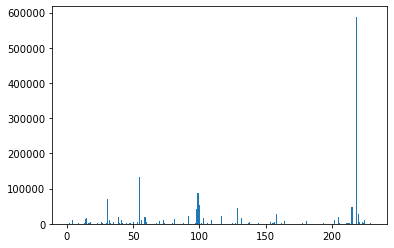

In [15]:
countr_na = dat.isnull().groupby(dat['prop_country_id']).sum()
plt.bar(countr_na.index, countr_na['orig_destination_distance'])

<BarContainer object of 129113 artists>

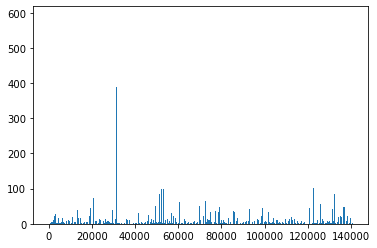

In [16]:
vis_na = dat.isnull().groupby(dat['prop_id']).sum()
plt.bar(vis_na.index, vis_na['orig_destination_distance'])

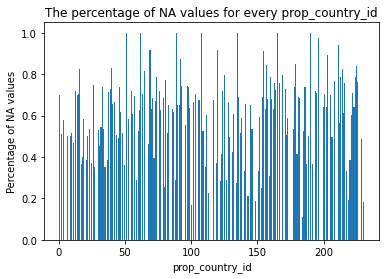

In [35]:
countr_na['orig_destination_distance']
dat['prop_country_id'].value_counts().sort_index()

country_na_df = pd.DataFrame({'na':countr_na['orig_destination_distance'], 'tot':dat['prop_country_id'].value_counts().sort_index()})
country_na_df['perc_na'] = country_na_df['na']/country_na_df['tot']
plt.bar(country_na_df.index, country_na_df['perc_na'])
plt.xlabel('prop_country_id')
plt.ylabel('Percentage of NA values')
plt.title('The percentage of NA values for every prop_country_id')
plt.savefig('perc_na_prop_country_id.png')

### Correlation

In [38]:
cor_book = dat.corr()['booking_bool']

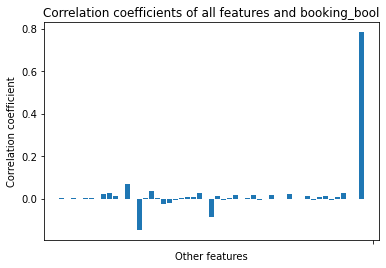

In [54]:
plt.bar(cor_book[cor_book.index != 'booking_bool'].index, cor_book[cor_book.index != 'booking_bool'].values)
plt.xticks('')
plt.xlabel('Other features')
plt.ylabel('Correlation coefficient')
plt.title('Correlation coefficients of all features and booking_bool')
plt.savefig('correlation_booking.png')

In [59]:
cor_click = dat.corr()['click_bool']

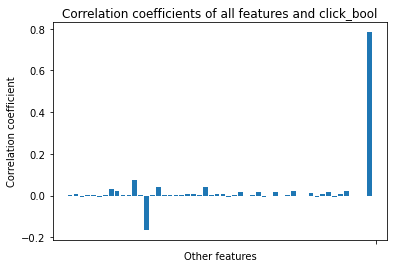

In [60]:
plt.bar(cor_click[cor_click.index != 'click_bool'].index, cor_click[cor_click.index != 'click_bool'].values)
plt.xticks('')
plt.xlabel('Other features')
plt.ylabel('Correlation coefficient')
plt.title('Correlation coefficients of all features and click_bool')
plt.savefig('correlation_click.png')

It can be seen that there is no clear linear correlation to be found. A simple linear predictor will therefore not work.

# Price - booking comparison

The dataset is really large right now. Let's first try to find some basic analytics with just some of the variables.

In [3]:
hotel_data = dat[['prop_id','price_usd','visitor_location_country_id','visitor_hist_starrating','visitor_hist_adr_usd', 'click_bool', 'booking_bool', 'gross_bookings_usd','srch_length_of_stay','srch_adults_count', 'srch_children_count']].sort_values('prop_id')
hotel_data = hotel_data[hotel_data['booking_bool'] != 0]
hotel_data['booking_p_night'] = hotel_data['gross_bookings_usd']/hotel_data['srch_length_of_stay']
hotel_data['booking_p_person'] = hotel_data['gross_bookings_usd']/(hotel_data['srch_children_count'] + hotel_data['srch_adults_count'])
hotel_data['booking_p_night_person'] = hotel_data['gross_bookings_usd']/hotel_data['srch_length_of_stay']/(hotel_data['srch_children_count'] + hotel_data['srch_adults_count'])

We made new variables to try compare the booking with the previous booking in the 'visitor_hist_adr_usd' variable. We first use Pearson's correlation test. 

In [4]:
hotel_data[['visitor_hist_adr_usd','booking_p_night','booking_p_person','booking_p_night_person']].corr()

,visitor_hist_adr_usd,booking_p_night,booking_p_person,booking_p_night_person
visitor_hist_adr_usd,1.000000,0.290151,0.109992,0.262573
booking_p_night,0.290151,1.000000,0.534495,0.836849
booking_p_person,0.109992,0.534495,1.000000,0.604983
booking_p_night_person,0.262573,0.836849,0.604983,1.000000


A convincing correlation cannot be found. This makes sense as we have no information about the previous booking, just the price per night. Based on that information, the booking_p_night variable should be the most comparible, but is barely better than the others. 

In [6]:
hotel_clustering = dat[['prop_country_id','prop_starrating','prop_review_score','prop_brand_bool','prop_location_score1','prop_location_score2','prop_log_historical_price','price_usd','promotion_flag']].dropna()

# Train - test split

In [4]:
import pandas as pd
dat = pd.read_csv('/Users/kuba/VU/DMT/data-mining-techniques/A2/100k_train_data.csv')

In [31]:
import random
def sample_ids(dat, test_prop): # test_prop is proportionate to the number of unique srch_id's, not number of instances

    unique_ids = list(dat['srch_id'].unique())
    n_sample = round(len(unique_ids) * test_prop) # test_prop must be between 0-1
    test_ids = random.sample(unique_ids,n_sample)
    
    return test_ids

def get_train_test(dat, test_prop):
    
    test_ids = sample_ids(dat, test_prop) # get ids for test set
    test_ids_df = pd.DataFrame({'srch_id':test_ids}) # convert to df for .merge function
    test = test_ids_df.merge(dat, on = 'srch_id', how = 'left')
    
    outer = dat.merge(test_ids_df, on = 'srch_id', how = 'outer', indicator = True)
    train = outer[(outer._merge=='left_only')].drop('_merge', axis=1)
    
    return train, test
    
random.seed(1)
train, test = get_train_test(dat, 0.3)

features_to_remove = ['click_bool','position','booking_bool', 'gross_bookings_usd']

test_data_sorted = test.sort_values(['srch_id','booking_bool', 'click_bool','position'], ascending = [True, False, False, True])
test_data_sorted.reset_index(drop=True, inplace=True)
# correct_order just needed for debugging
correct_order = test_data_sorted[['srch_id', 'prop_id']]
test_data_without_labels = test_data_sorted.drop(features_to_remove, axis=1)
test_data_with_labels = test_data_sorted


In [32]:
test_data_without_labels.to_csv('split_test_inference_data_100k.csv')
test_data_with_labels.to_csv('split_test_data_100k.csv')
train.to_csv('split_train_data_100k.csv')